In [6]:
%matplotlib inline
# %matplotlib widget

import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from remezlp import *

In [7]:
def rfiq(x, NyqZones):
    rfi = np.ones(NyqZones)
    rfi[NyqZones//4:NyqZones//2] = 0
    rfi[NyqZones//2:3*NyqZones//4] = -1
    rfi[3*NyqZones//4:] = 0
    
    rfq = np.ones(NyqZones)
    rfq[:NyqZones//4] = 0
    rfq[NyqZones//2:3*NyqZones//4] = 0
    rfq[3*NyqZones//4:] = -1
    
    x_upsampled = np.zeros((len(x)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
    x_upsampled[::NyqZones] = x
    
    x_rfi = np.convolve(rfi, x_upsampled.real)
    x_rfq = np.convolve(rfq, x_upsampled.imag)
    x_rfiq = x_rfi + x_rfq
    return x_rfiq

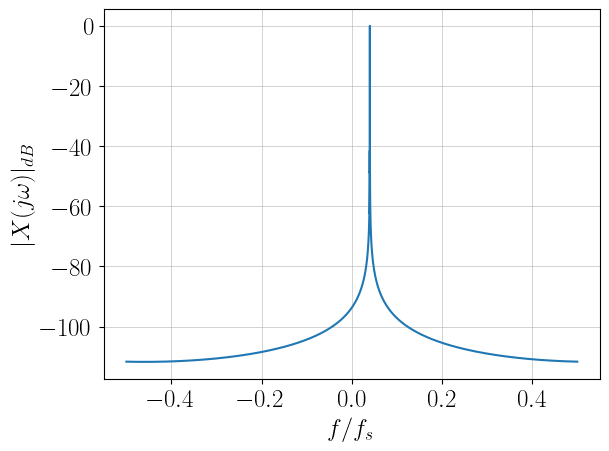

In [8]:
N = 2**16
n = np.arange(N)
f = 3.2 * 1.0e3
fs = 10 * 1.0e3
F = f/fs
M = 3
OSR = 8
NyqZones = 4

x = 2**(M-1) * np.exp(1j * 2*np.pi*F*n/OSR)

w = signal.hamming(len(x), False)
x *= w
XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))
XdB -= np.max(XdB)
freqs = np.arange(len(x)) / len(x) - 0.5

plt.plot(freqs, XdB)
plt.grid(linewidth=0.4)
plt.xlabel(r'$f/f_s$')
plt.ylabel(r'$|X(j\omega)|_{dB}$')
plt.show();

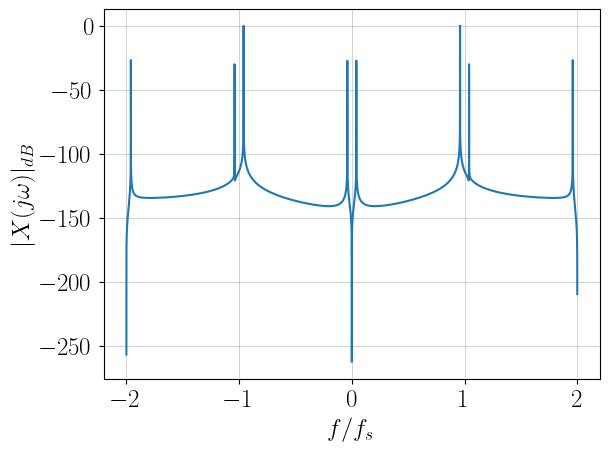

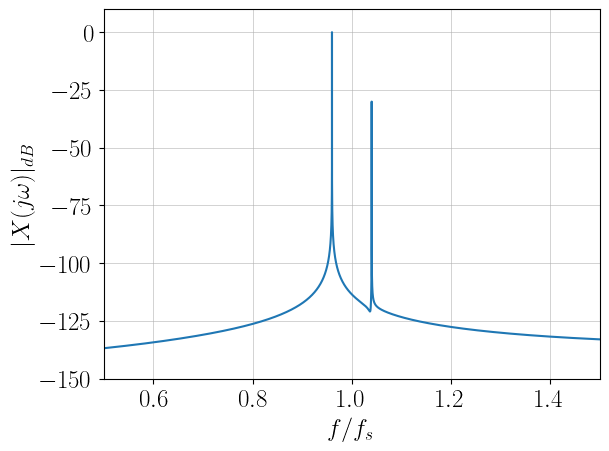

In [9]:
x_rfiq = rfiq(x, NyqZones)

w = signal.hamming(len(x_rfiq), False)
x_rfiq *= w
XrfiqdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_rfiq))))
XrfiqdB -= np.max(XrfiqdB)
freqs_rfiq = (np.arange(len(x_rfiq)) / len(x_rfiq) - 0.5) * NyqZones

plt.plot(freqs_rfiq, XrfiqdB)
plt.grid(linewidth=0.4)
plt.xlabel(r'$f/f_s$')
plt.ylabel(r'$|X(j\omega)|_{dB}$')
plt.show();

plt.plot(freqs_rfiq, XrfiqdB)
plt.grid(linewidth=0.4)
plt.xlabel(r'$f/f_s$')
plt.ylabel(r'$|X(j\omega)|_{dB}$')
plt.xlim([0.5, 1.5])
plt.ylim([-150, 10])
plt.show();

In [10]:
def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)
    
def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I, dtype=complex)
    xI[::I] = x
    return xI

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def plotdB(x, win=False, epsilon=1e-12):
    if win==True:
        w = signal.hamming(len(x), False)
        x *= w
    x += epsilon
    XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))
    XdB -= np.max(XdB)
    freqs = np.arange(len(x))/len(x) - 0.5

    plt.plot(freqs, XdB)
    plt.grid()
    # plt.show();

def plot(x, win=False, epsilon=1e-15):
    if win==True:
        w = signal.hann(len(x), False)
        x *= w
    Xfft = np.abs(np.fft.fftshift(np.fft.fft(x)))
    Xfft /= np.max(Xfft)
    freqs = np.arange(len(x))/len(x) - 0.5
    plt.plot(freqs, Xfft)
    plt.grid()
    

def makePolyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff)/M))
    tmp = np.zeros(n*M)
    tmp[:len(coeff)] = coeff
    polyCoeff = np.zeros((M,n))
    for i in range(M):
        polyCoeff[i,:] = tmp[i::M]
    return polyCoeff

def polyI(x, firCoeff, I):
    polyFIR = makePolyphase(firCoeff, I)
    xPoly = np.zeros(len(x)*I, dtype=type(x))
    for i in range(I):
        tmp = signal.lfilter(polyFIR[i], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
        tmp = tmp[int(len(firCoeff)/I-1):]
        xPoly[i::I] = tmp
    return xPoly

def polyD(x, firCoeff, D):
    polyFIR = makePolyphase(firCoeff, I)
    x_ = np.concatenate((x, x[:int(len(firCoeff)-1)]))
    y = []
    for i in range(D):
        FIRin = x_[i::D]
        tmp = signal.lfilter(polyFIR[D-1-i], 1.0, FIRin)
        tmp = tmp[int(len(firCoeff)/D):]
        y = np.append(y, tmp)
    y = np.array(y)
    return y

def fftdB(x, epsilon=1e-12):
    return 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))

### Polyphase Interpolation

In [11]:
N = 2**16
n = np.arange(N)
f = 3.2 * 1.0e3
fs = 10 * 1.0e3
F = f/fs
Fmax = 0.4
M = 3
I = 16

Fmax = 0.4
Fpass = Fmax
Fstop = 1 - Fpass
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

# x = 2**(M-1) * np.exp(1j * 2*np.pi*F*n)

F = [0.0, Fmax]
A = [1.0, 1.0]
x = 2*genTestSpectrum(N, F, A, True).real
amp = 1e-6
x += np.random.normal(-amp, amp, len(x))

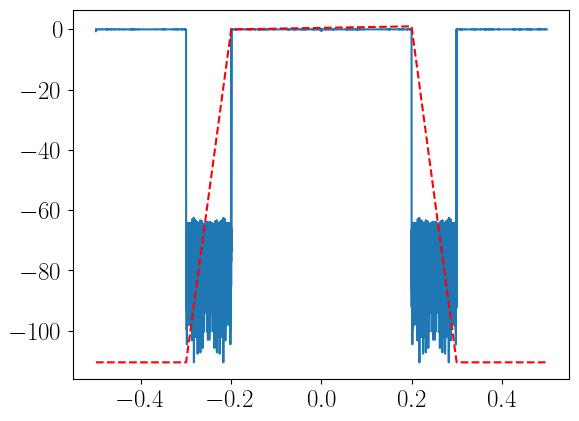

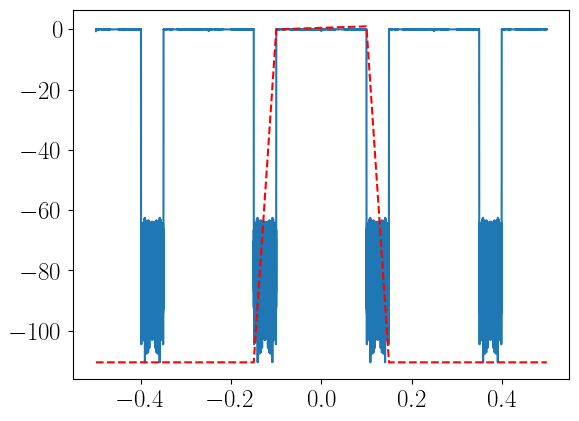

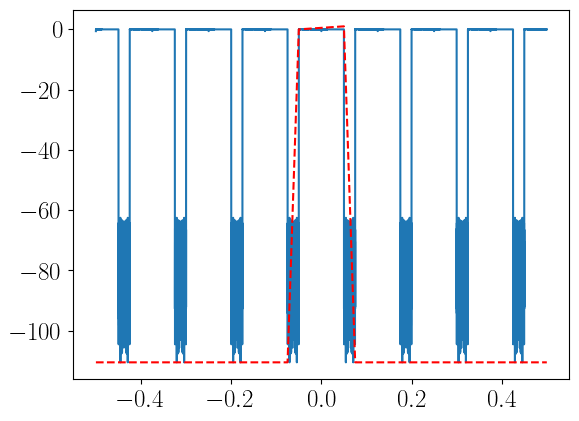

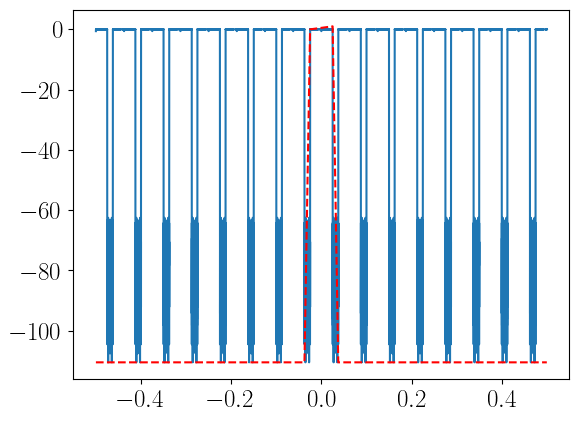

In [12]:
iterator = int(np.log(I)/np.log(2))
xI = x
Fpass_ = Fpass
Fstop_ = Fstop

for i in range(iterator):
    xI = expander(xI, 2)
    XIdB = fftdB(xI)
    XIdB -= np.max(XIdB)
    freqs = np.arange(len(xI)) / len(xI) - 0.5

    Fpass_ /= 2
    Fstop_ /= 2

    plt.plot(freqs, XIdB)
    plt.plot([-0.5, -Fstop_, -Fpass_, Fpass_, Fstop_, 0.5], [np.min(XIdB), np.min(XIdB), np.max(XIdB), 1, np.min(XIdB), np.min(XIdB)], '--r')
    plt.show();

N = 22


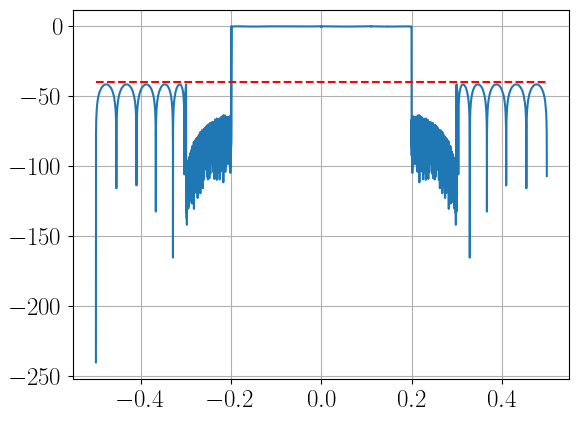

N = 42


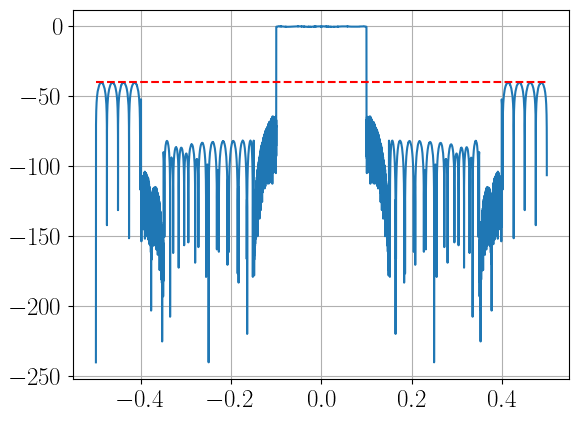

N = 83


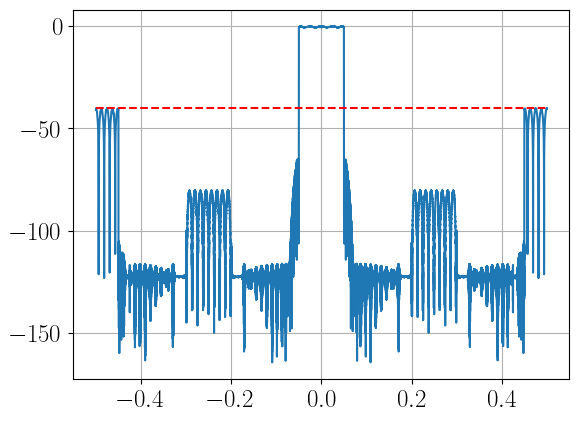

N = 165


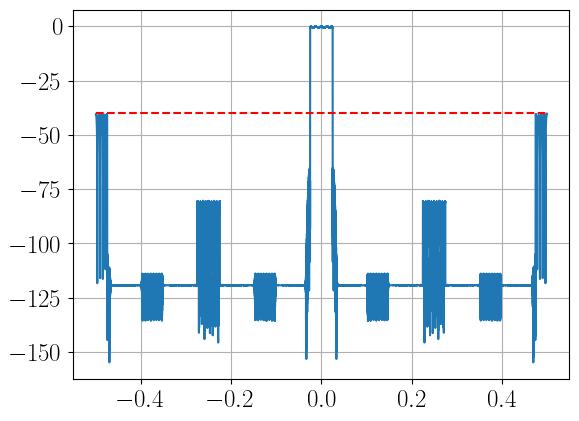

In [13]:
iterator = int(np.log(I)/np.log(2))
xI = x
Fpass_ = Fpass
Fstop_ = Fstop

for i in range(iterator):
    Fpass_ /= 2
    Fstop_ /= 2
    firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=500)
    print(f"N = {len(firCoeff)}")
    # firCoeff = firCoeff[1:-1]

    # xI = expander(xI, 2)
    # xI = signal.lfilter(firCoeff, 1.0, np.concatenate((xI, xI[:len(firCoeff)-1])))[len(firCoeff)-1:]    
    xI = polyI(xI, firCoeff, 2)
    
    plotdB(xI)
    plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
    plt.show();

# Polyphase Decimation

In [14]:
N = 2**16
n = np.arange(N)
f = 3.2 * 1.0e3
fs = 10 * 1.0e3
F = f/fs
Fmax = 0.4
M = 3
D = 16

Fmax = 0.4 / D

transitionWidth = 0.1 / D       # (Fmax + transitionWidth) * D <= 0.5
Fpass = Fmax
Fstop = Fmax + transitionWidth
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

# x = 2**(M-1) * np.exp(1j * 2*np.pi*F*n)

F = [0.0, Fmax]
A = [1.0, 1.0]
x = 2*genTestSpectrum(N, F, A, True).real
amp = 1e-6
x += np.random.normal(-amp, amp, len(x))

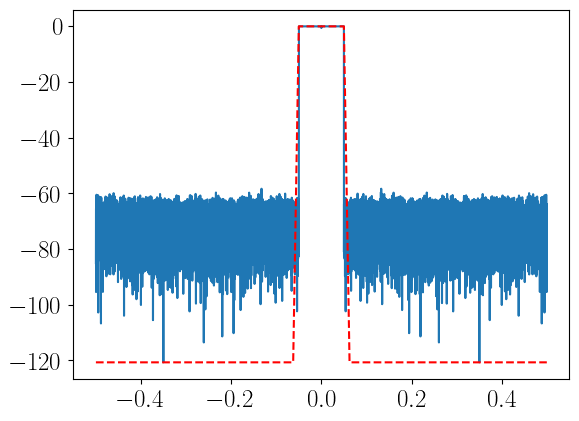

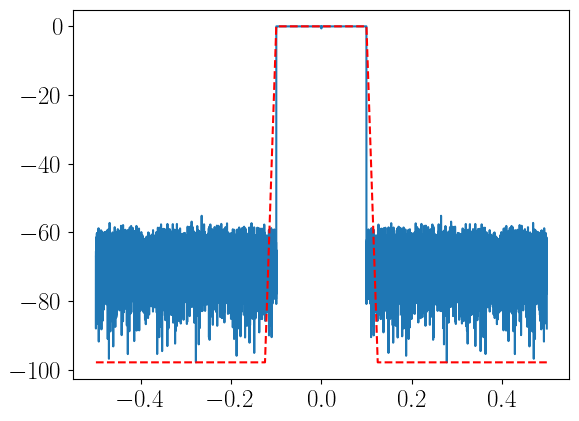

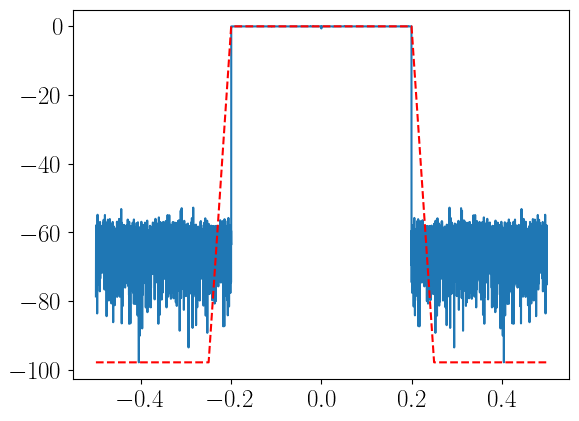

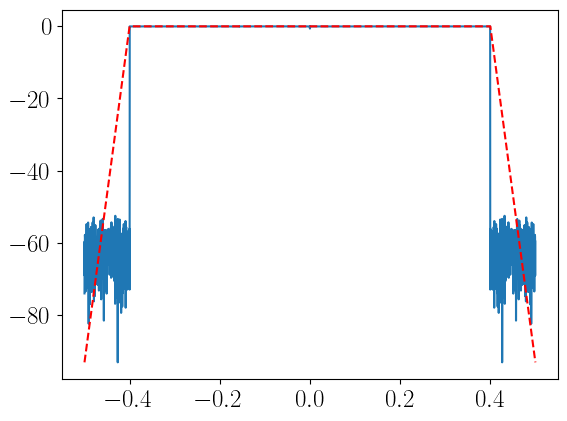

In [15]:
iterator = int(np.log(I)/np.log(2))
xD = x
Fpass_ = Fpass
Fstop_ = Fstop

for i in range(iterator):
    xD = compressor(xD, 2)
    XDdB = fftdB(xD)
    XDdB -= np.max(XDdB)
    freqs = np.arange(len(xD)) / len(xD) - 0.5

    Fpass_ *= 2
    Fstop_ *= 2

    plt.plot(freqs, XDdB)
    plt.plot([-0.5, -Fstop_, -Fpass_, Fpass_, Fstop_, 0.5], [np.min(XDdB), np.min(XDdB), np.max(XDdB), np.max(XDdB), np.min(XDdB), np.min(XDdB)], '--r')
    plt.show();

N = 161


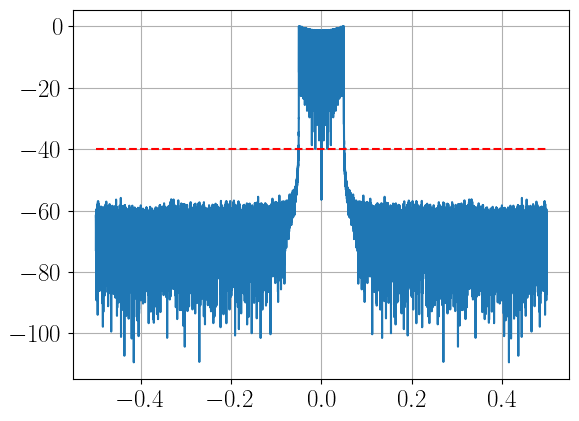

N = 82


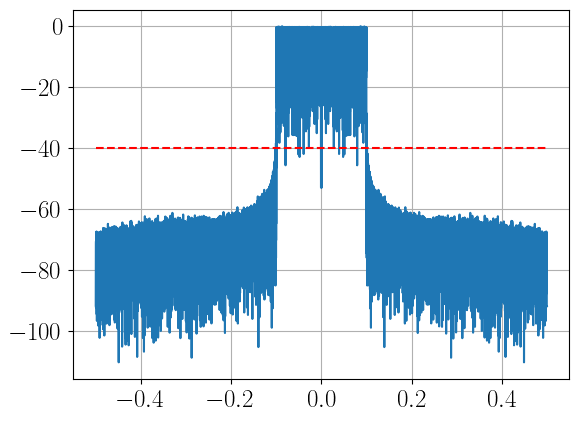

N = 42


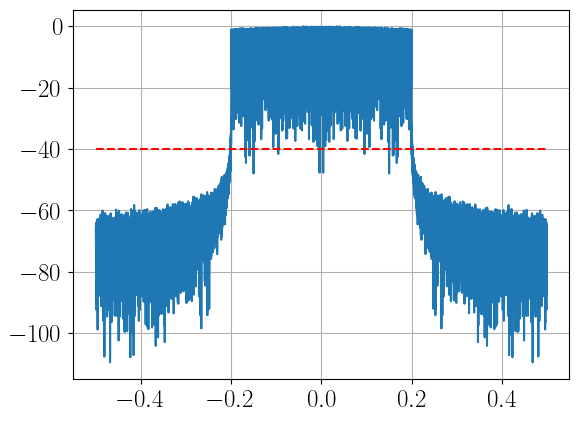

N = 18


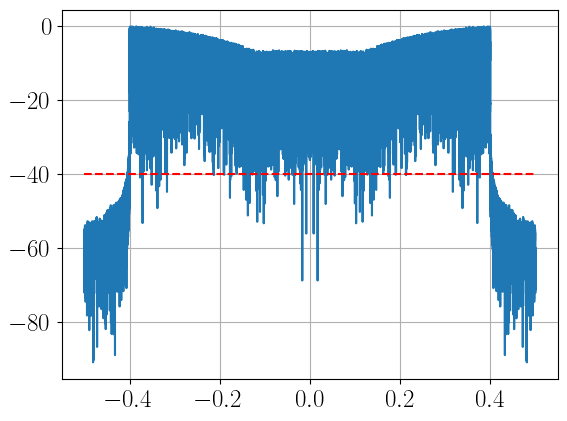

In [16]:
iterator = int(np.log(D)/np.log(2))
xD = x
Fpass_ = Fpass
Fstop_ = Fstop

for i in range(iterator):
    Fpass_ *= 2
    Fstop_ *= 2
    firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=500)
    print(f"N = {len(firCoeff)}")
    # firCoeff = firCoeff[1:-1]

    # xD = compressor(xD, 2)
    # xD = signal.lfilter(firCoeff, 1.0, np.concatenate((xD, xD[:len(firCoeff)-1])))[len(firCoeff)-1:]    
    xD = polyD(xD, firCoeff, 2)
    
    plotdB(xD, win=True)
    plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
    plt.show();

In [17]:
N = 2**12
n = np.arange(N)
f = 0.5 * 1e3
fs = 10 * 1e3
F = f/fs
M = 1
I = 8

Fmax = 0.4
Fpass = Fmax
Fstop = 1 - Fpass
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

x = 2**(M-1) * np.exp(1j * 2*np.pi*F*n)
x = x.real

amp = 1e-6
x += np.random.normal(-amp, amp, len(x))

<StemContainer object of 3 artists>

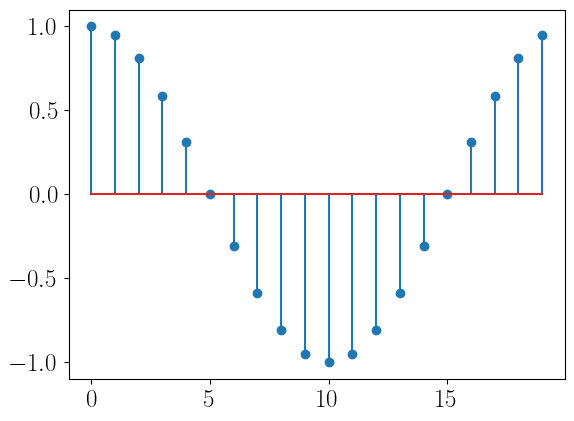

In [18]:
plt.stem(x[:20])

In [19]:
def polyI(x, firCoeff, I):
    polyFIR = makePolyphase(firCoeff, I)
    xPoly = np.zeros(len(x)*I, dtype=type(x))
    for i in range(I):
        tmp = signal.lfilter(polyFIR[i], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
        tmp = tmp[int(len(firCoeff)/I-1):]
        xPoly[i::I] = tmp
    return xPoly

I = 4
Fpass_ = Fpass / I
Fstop_ = Fstop / I
firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=500)

polyFIR = makePolyphase(firCoeff, I)
tmp = signal.lfilter(polyFIR[-1], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
# tmp = tmp[int(len(firCoeff)/I/2):]
x_delayed = tmp

commonDelay = int((len(firCoeff)-1) / (2*I))

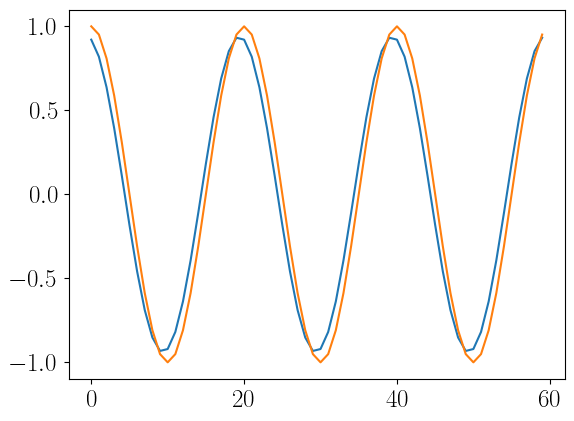

In [20]:
x_ = x_delayed
x_ /= np.max(x_[40:])
plt.plot(x_[40+commonDelay:100+commonDelay])
plt.plot(x[40:100])

In [21]:
N = 2**12
n = np.arange(N)
f = 0.5 * 1e3
fs = 10 * 1e3
F = f/fs
M = 1
I = 8

Fmax = 0.4
Fpass = Fmax
Fstop = 1 - Fpass
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

x = 2**(M-1) * np.exp(1j * 2*np.pi*F*n)

amp = 1e-6
x += np.random.normal(-amp, amp, len(x))

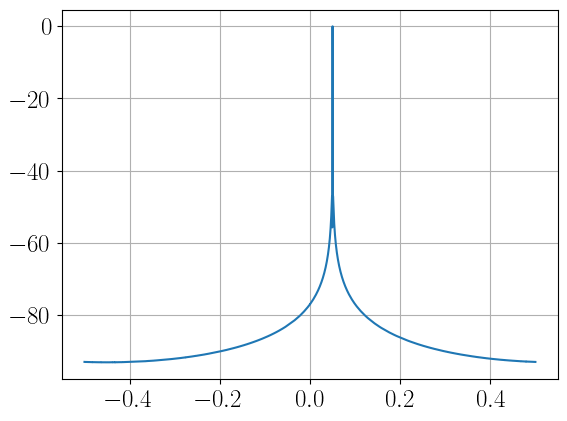

In [22]:
XdB = fftdB(x)
plotdB(x, win=True)

N = 11


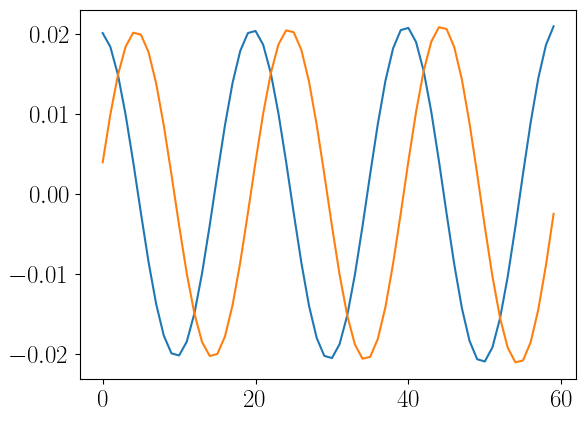

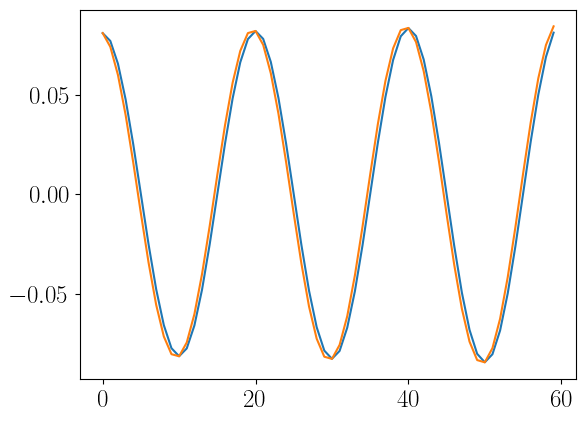

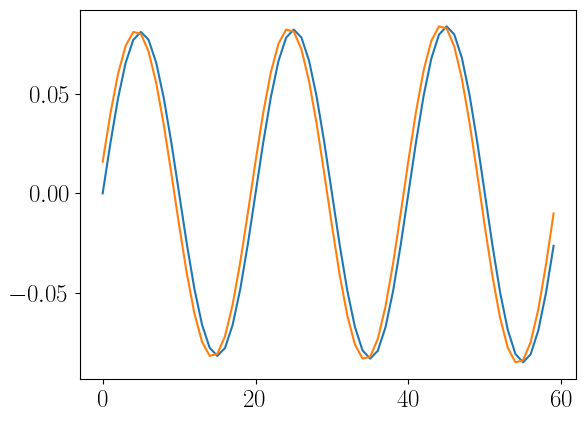

In [23]:
I = 4
NyqZones = 4

x_real = x.real
x_imag = x.imag

firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=500)
polyFIR = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff)-1) / (2*I))
print(f"N = {len(polyFIR[-1])}")

x_real_ = signal.lfilter(polyFIR[-2], 1.0, np.concatenate((x_real, x_real[:int(len(firCoeff)/I-1)])))
x_imag_ = signal.lfilter(polyFIR[-1], 1.0, np.concatenate((x_imag, x_imag[:int(len(firCoeff)/I-1)])))

plt.plot(x_real_[40+commonDelay:100+commonDelay])
plt.plot(x_imag_[40+commonDelay:100+commonDelay])
plt.show();

plt.plot(x_real[40:100]/np.max(x_real))
plt.plot(x_real_[40+commonDelay:100+commonDelay]/np.max(x_real_[40:]))
plt.show();

plt.plot(x_imag[40:100]/np.max(x_imag))
plt.plot(x_imag_[40+commonDelay:100+commonDelay]/np.max(x_imag_[40:]))
plt.show();

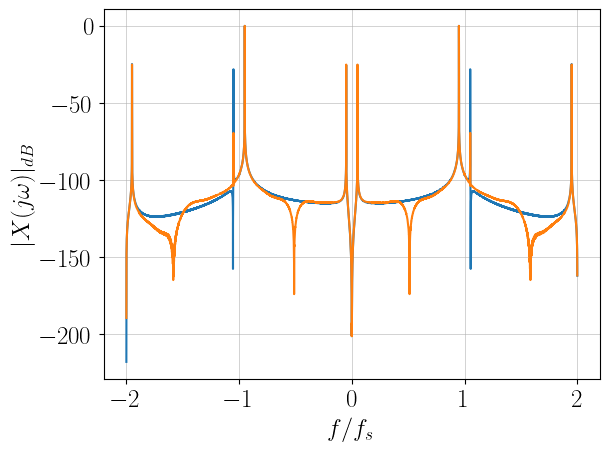

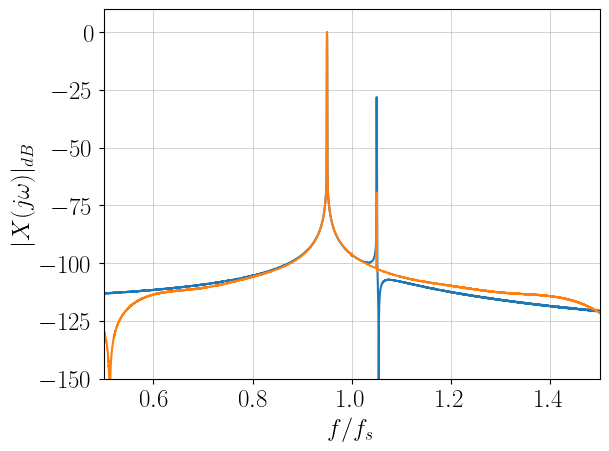

In [24]:
x_real_ = x_real_[int(len(firCoeff)/I-1):]
x_imag_ = x_imag_[int(len(firCoeff)/I-1):]
x_ = x_real_ + 1j*x_imag_
x_rfiq_ = rfiq(x_, NyqZones)

w = signal.hamming(len(x_rfiq_), False)
x_rfiq_ *= w
XrfiqdB_ = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_rfiq_))))
XrfiqdB_ -= np.max(XrfiqdB_)
freqs_rfiq_ = (np.arange(len(x_rfiq_)) / len(x_rfiq_) - 0.5) * NyqZones

x_rfiq = rfiq(x, NyqZones)
w = signal.hamming(len(x_rfiq), False)
x_rfiq *= w
XrfiqdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_rfiq))))
XrfiqdB -= np.max(XrfiqdB)
freqs_rfiq = (np.arange(len(x_rfiq)) / len(x_rfiq) - 0.5) * NyqZones

plt.plot(freqs_rfiq, XrfiqdB)
plt.plot(freqs_rfiq_, XrfiqdB_)
plt.grid(linewidth=0.4)
plt.xlabel(r'$f/f_s$')
plt.ylabel(r'$|X(j\omega)|_{dB}$')
plt.show();

plt.plot(freqs_rfiq, XrfiqdB)
plt.plot(freqs_rfiq_, XrfiqdB_)
plt.grid(linewidth=0.4)
plt.xlabel(r'$f/f_s$')
plt.ylabel(r'$|X(j\omega)|_{dB}$')
plt.xlim([0.5, 1.5])
plt.ylim([-150, 10])
plt.show();

/tmp/ipykernel_3423/3563647740.py:40: RuntimeWarning: divide by zero encountered in log10
  XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))


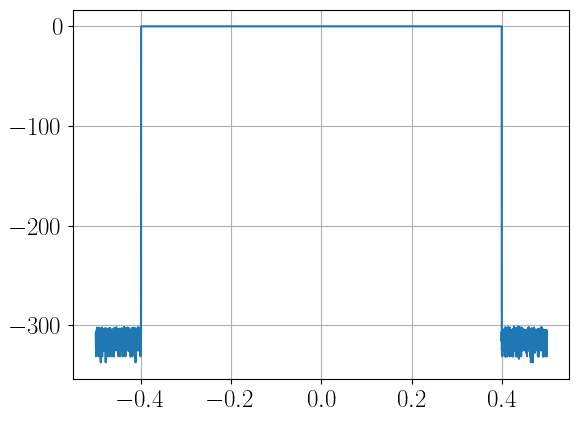

In [11]:
F = [0.0, 0.2]
A = [1.0, 1.0]
x = 2*genTestSpectrum(N, F, A, True).real

x_ = compressor(x, 2)
plotdB(x_)